# ADA project - Milestone 2

## Part 1 : pre-processing and statistics

In [66]:
# Imports of necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# import the CMU movie datasets
movie_column_names = ['Wikipedia_movie_ID',
                'Freebase_movie_ID',
                'movie_name',
                'movie_release_date',
                'movie_box_office_revenu',
                'movie_runtime',
                'movie_languages',
                'movie_countries',
                'movie_genres']

df_movies = pd.read_csv("MovieSummaries\movie.metadata.tsv", delimiter='\t', names = movie_column_names)
df_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', delimiter='\t', names=['movie_ID', 'movie_summary'])

#### 1.2) Processing a relational table to link every movies to every genre

The genre given to a movies is a easy and quick approach to get a first subset of fictional movies. Therefore, since multiple genre are given per movie, we extracted all genres into a new dataframe as a relational table between movies and genre.

In [10]:
# Split genres into a list of dictionaries
genres_list = df_movies['movie_genres'].apply(lambda x: eval(x) if pd.notna(x) else {})

# Initialize an empty list to store rows of the new Dataframe
new_rows = []

# Iterate over each row and process the genre dictionaries into new rows related to movie_id
for i, genres_dict in enumerate(genres_list):
    movie_id = df_movies.loc[i, 'Wikipedia_movie_ID']

    for genre_id, genre_name in genres_dict.items():
        new_rows.append({'Wikipedia_movie_ID': movie_id, 'Freebase_genre_ID': genre_id, 'movie_genre': genre_name})

# Create a new DataFrame from the list of rows
df_genres = pd.DataFrame(new_rows)

# Save the new DataFrame to a CSV file
df_genres.to_csv('cleaned_genres.csv', index=False)

# Display the genres related DataFrame
print(df_genres.head())

   Wikipedia_movie_ID Freebase_genre_ID      movie_genre
0              975900         /m/01jfsb         Thriller
1              975900          /m/06n90  Science Fiction
2              975900          /m/03npn           Horror
3              975900         /m/03k9fj        Adventure
4              975900          /m/0fdjb     Supernatural


### 1.3) All unique mentioned genres and their relative appearance

In [87]:
unique_genres = df_genres[['Freebase_genre_ID','movie_genre']].groupby('movie_genre', as_index=False).aggregate([pd.Series.mode, 'count']).copy()
unique_genres.columns = ['Freebase_ID', 'movie_count']
unique_genres = unique_genres.sort_values(by='movie_count', ascending=False)
unique_genres


,Freebase_ID,movie_count
movie_genre,,
Drama,/m/07s9rl0,34007
Comedy,/m/01z4y,16349
Romance Film,/m/02l7c8,10234
Black-and-white,/m/01g6gs,9094
Action,/m/02kdv5l,8798
...,...,...
Comdedy,/m/0bbctgg,1
New Queer Cinema,/m/022wy7,1
Linguistics,/m/0hj3nb2,1


Text(0.5, 0, 'Count of movies associated to the genre')

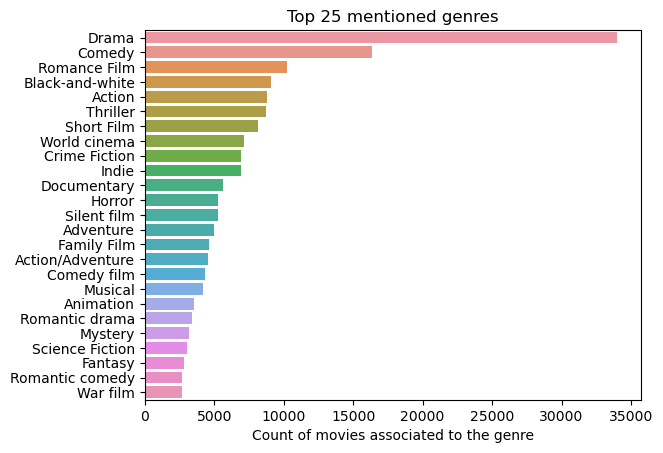

In [135]:
sns.barplot(data = unique_genres[['movie_count']].head(25).reset_index(),
            x = 'movie_count', y = 'movie_genre', orientation = 'horizontal')
plt.title("Top 25 mentioned genres")
plt.ylabel("")
plt.xlabel("Count of movies associated to the genre")

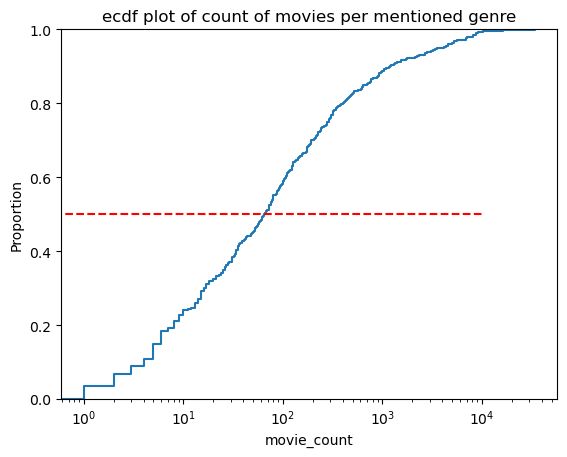

In [112]:
sns.ecdfplot(data = unique_genres, x = 'movie_count', log_scale=True)
plt.title("ecdf plot of count of movies per mentioned genre")
plt.hlines(y = 0.5, xmin = 0, xmax=1e4, linestyles='--', color = 'red')
# This would mean that 50% of the genres 

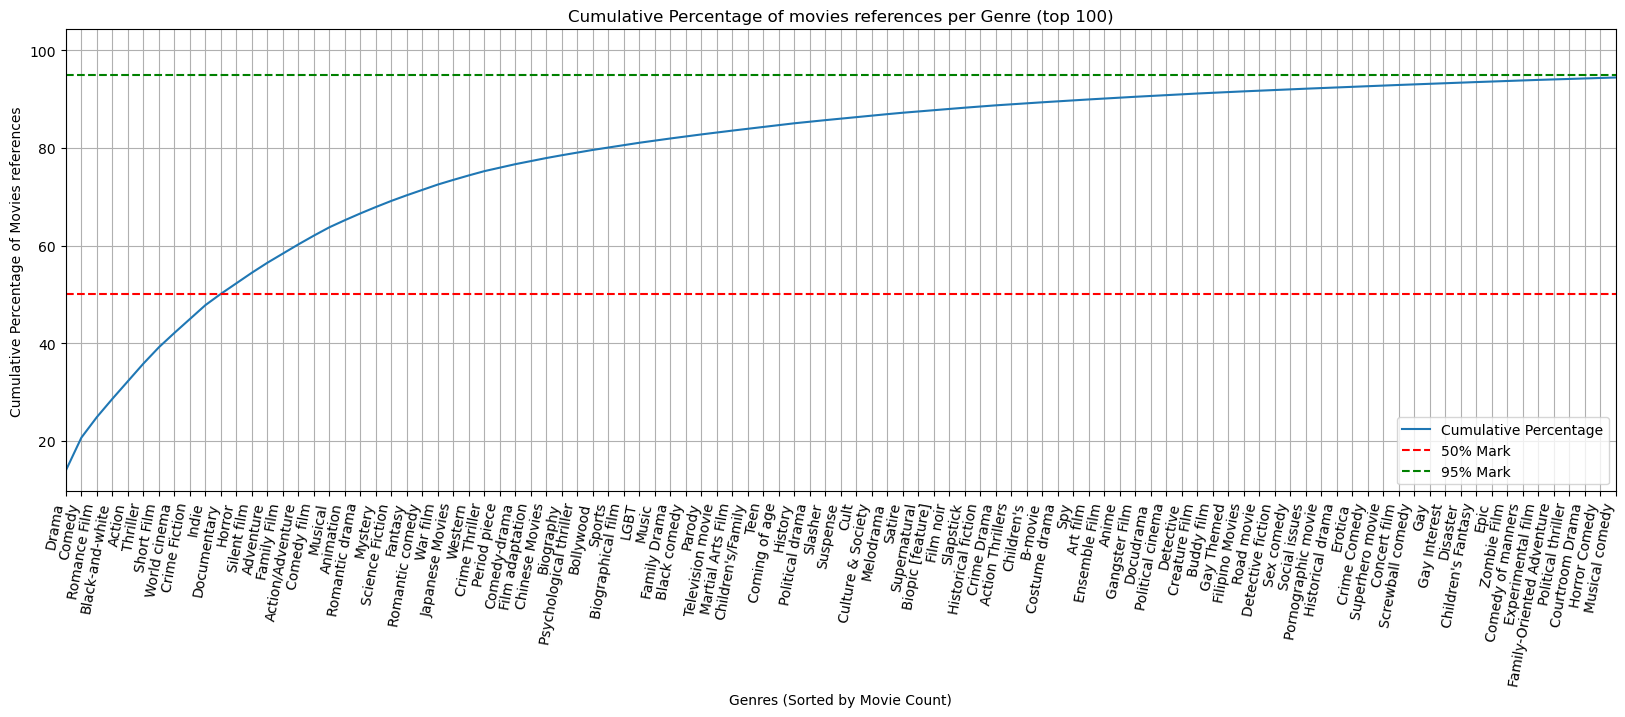

In [162]:
# Plot a cumulative percentage of movies by genre
plt.figure(figsize=(20, 6))
plt.plot((unique_genres['movie_count'].cumsum() / unique_genres['movie_count'].sum()) * 100,
         label='Cumulative Percentage')
plt.xticks(rotation=80, ha='right')
plt.xlim([0,100])

# Highlight the 50% and 90% mark
plt.axhline(y=50, color='r', linestyle='--', label='50% Mark')
plt.axhline(y=95, color='g', linestyle='--', label='95% Mark')

# Set labels and title
plt.xlabel('Genres (Sorted by Movie Count)')
plt.ylabel('Cumulative Percentage of Movies references')
plt.title('Cumulative Percentage of movies references per Genre (top 100)')
plt.legend()
plt.grid(True)
plt.show()

With this we can observe that if we take only the top 100 genres, almost 95% of the movie-genre relations are covered. 